In [4]:
import os, glob
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.signal import lfilter
from statsmodels.tsa.ar_model import AutoReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from scipy.signal import spectrogram
!pip install antropy
from antropy import sample_entropy
import pywt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA



In [6]:
import os
from google.colab import drive

drive.mount('/content/drive')

print("\nInstalling p7zip-full...")
!apt-get install -y p7zip-full

zip_file_path = '/content/drive/MyDrive/sEMG_RAW_2_CH/EMG_2Chs.7z'

extract_path = './EMG_2Chs_extracted'
os.makedirs(extract_path, exist_ok=True)

print(f"\nUnzipping {zip_file_path} to {extract_path}...")
!7z x "{zip_file_path}" -o"{extract_path}"

print(f"\nSuccessfully unzipped to: {extract_path}")
print("\nContents:")
!ls -R "{extract_path}"


Mounted at /content/drive

Installing p7zip-full...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.

Unzipping /content/drive/MyDrive/sEMG_RAW_2_CH/EMG_2Chs.7z to ./EMG_2Chs_extracted...

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/sEMG_RAW_2_CH/                                               1 file, 62694409 bytes (60 MiB)

Extracting archive: /content/drive/MyDrive/sEMG_RAW_2_CH/EMG_2Chs.7z
--
Path = /content/drive/MyDrive/sEMG_RAW_2_CH/EMG_2Chs.7z
Type = 7z
Physical Size = 62694409
Headers Size = 6537
Method =

# Data Preprocessing

In [7]:
DATA_DIR = "./EMG_2Chs_extracted"

label_map = {
    "T-T": 0,
    "I-I": 1,
    "M-M": 2,
    "R-R": 3,
    "L-L": 4,
    "T-I": 5,
    "T-M": 6,
    "T-R": 7,
    "T-L": 8,
    "HC":  9
}

In [8]:
all_signals = []
all_labels = []
example_signals = {}

In [9]:
subjects = sorted(glob.glob(os.path.join(DATA_DIR, "EMG-S*")))
print("subjects: {}".format(subjects))

subjects: ['./EMG_2Chs_extracted/EMG-S1', './EMG_2Chs_extracted/EMG-S10', './EMG_2Chs_extracted/EMG-S2', './EMG_2Chs_extracted/EMG-S3', './EMG_2Chs_extracted/EMG-S4', './EMG_2Chs_extracted/EMG-S5', './EMG_2Chs_extracted/EMG-S6', './EMG_2Chs_extracted/EMG-S7', './EMG_2Chs_extracted/EMG-S8', './EMG_2Chs_extracted/EMG-S9']


In [10]:
for subj_path in subjects:
    csv_files = glob.glob(os.path.join(subj_path, "*.csv"))

    for f in csv_files:
        fname = os.path.basename(f)

        if fname.startswith("HC"):
            class_prefix = "HC"
        else:
            class_prefix = fname[0] + "-" + fname[2]

        label = label_map[class_prefix]

        if label not in example_signals:
            data = pd.read_csv(f, header=None).values
            ch2 = data[:, 1]
            example_signals[label] = ch2

        data = pd.read_csv(f, header=None).values

        ch2 = data[:, 1]

        all_signals.append(ch2)
        all_labels.append(label)

In [11]:
all_signals = np.array(all_signals, dtype=object)
all_labels = np.array(all_labels)

In [12]:
print("\nLoaded signals:", len(all_signals))
print("Unique labels:", np.unique(all_labels))
print("Example channel length:", len(all_signals[0]))


Loaded signals: 600
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Example channel length: 20000


# Visualization

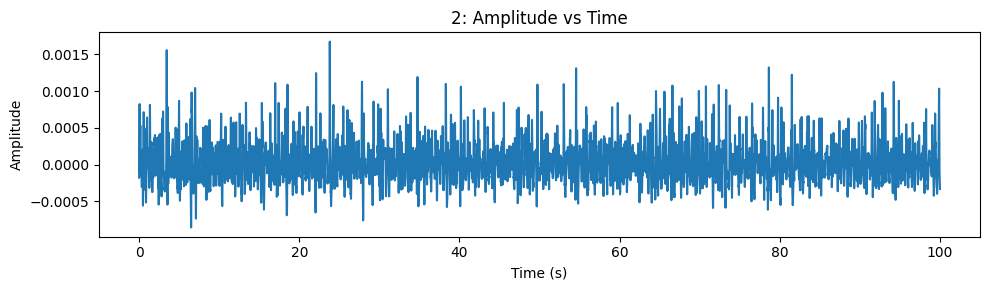

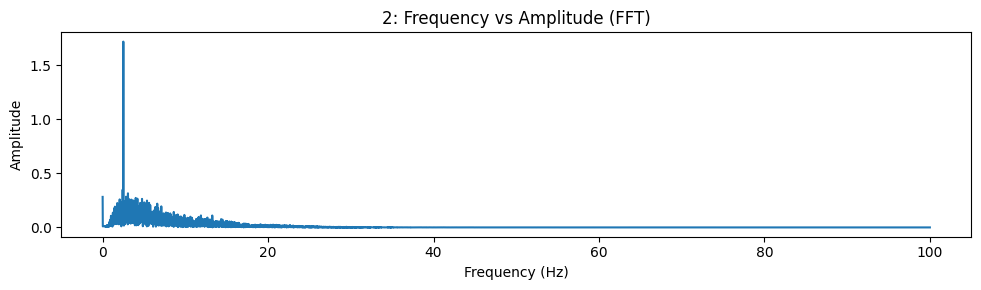

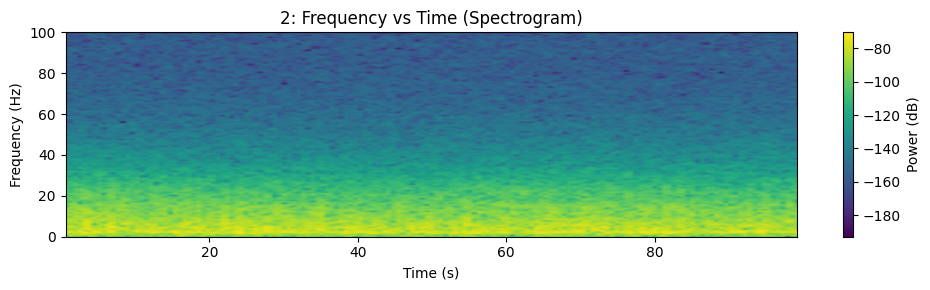

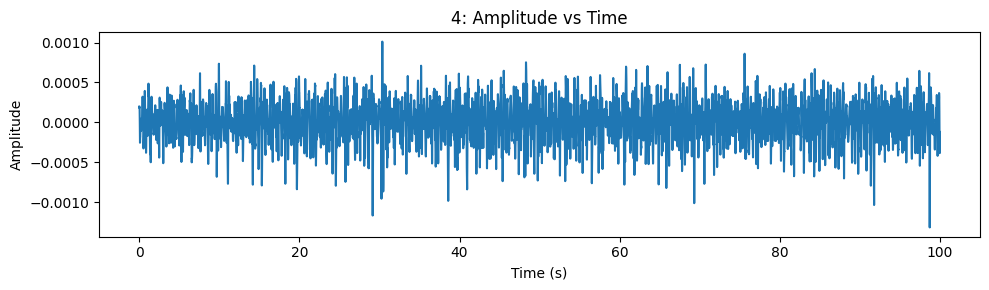

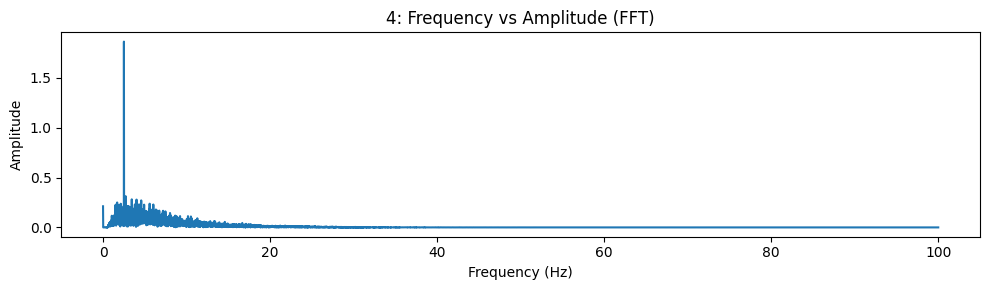

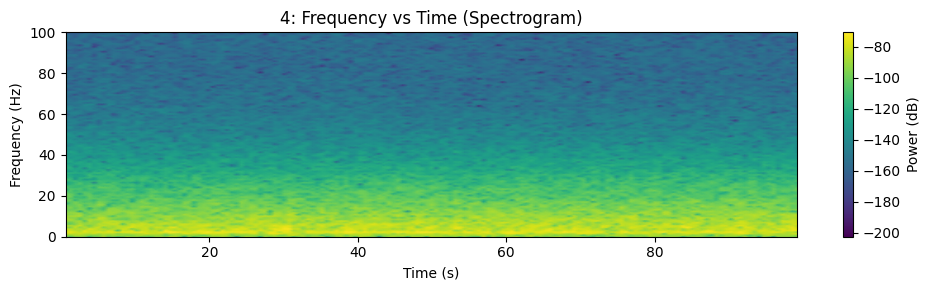

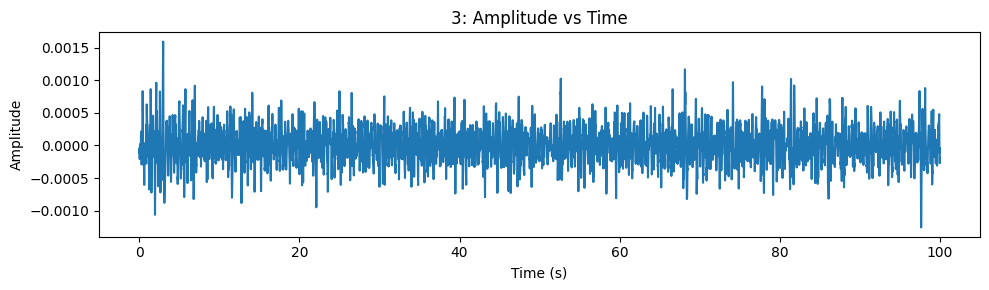

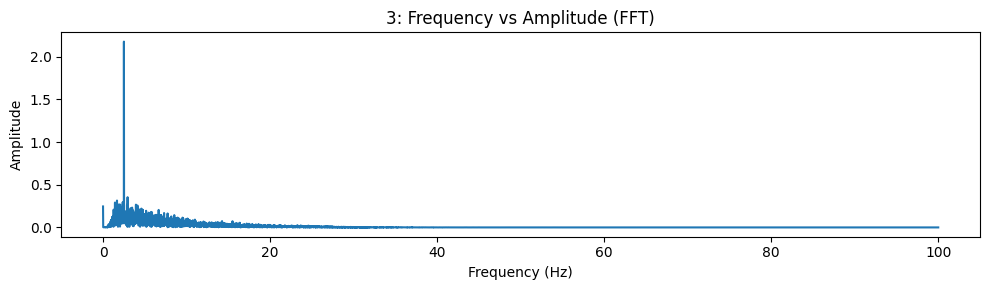

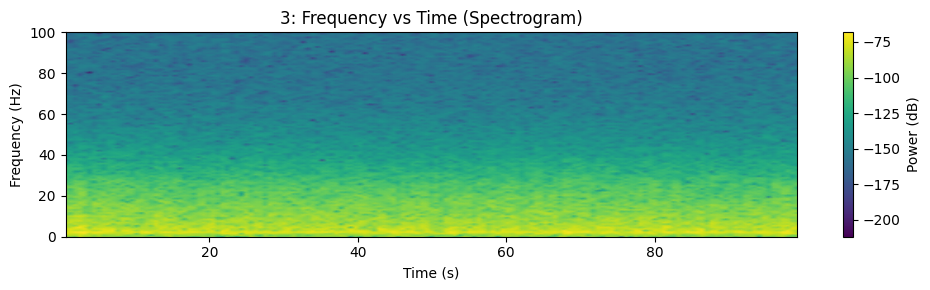

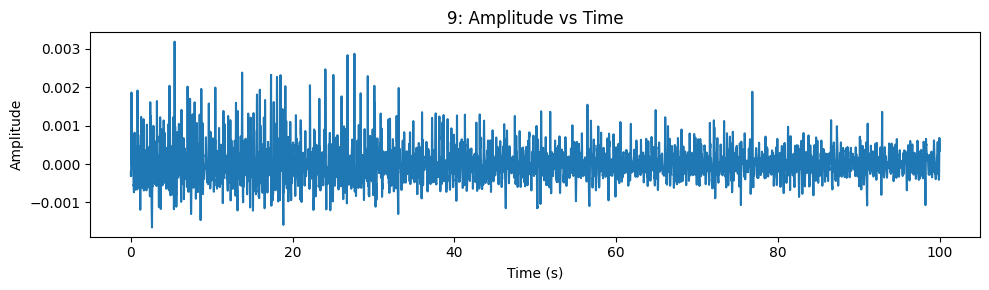

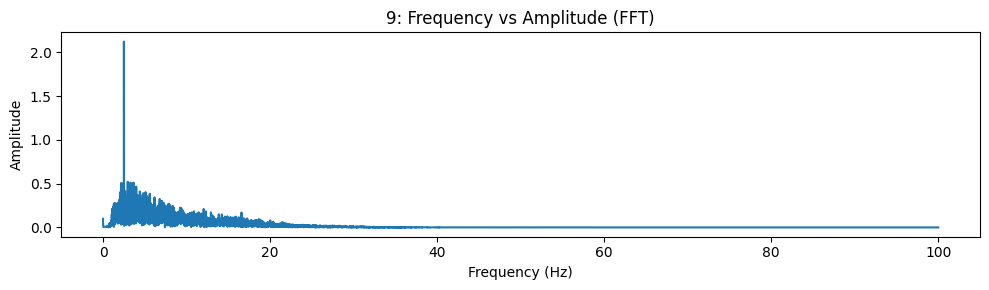

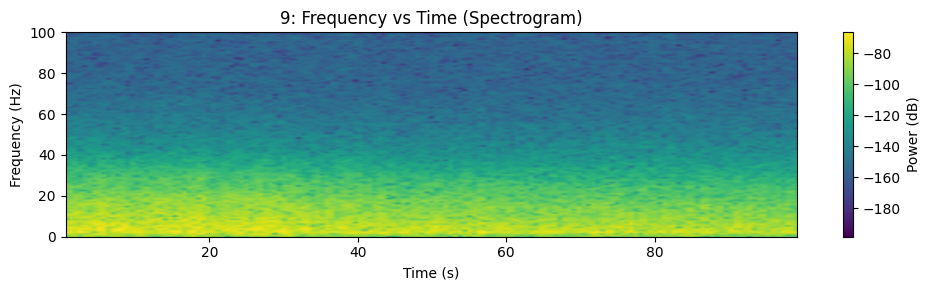

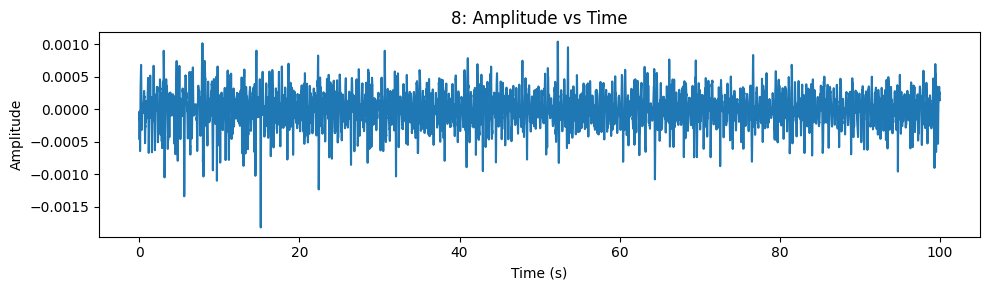

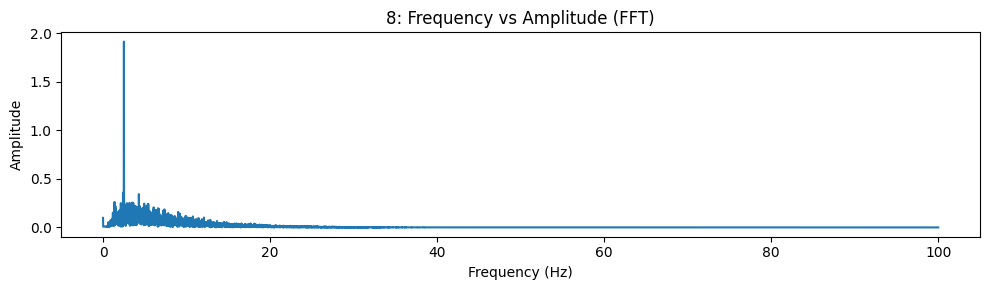

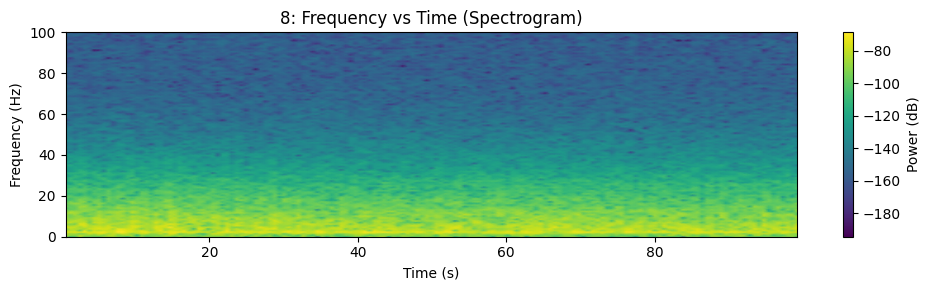

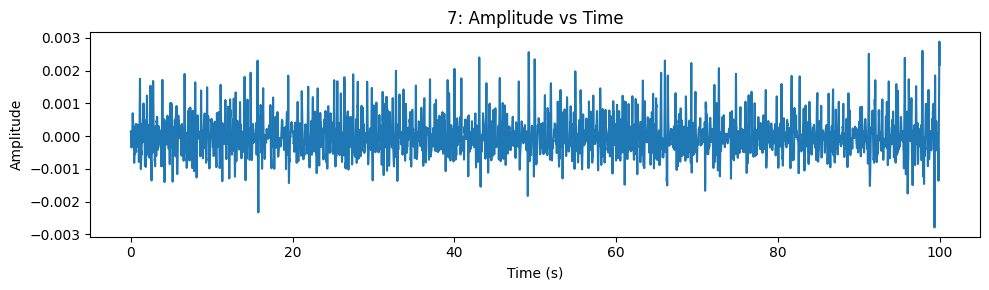

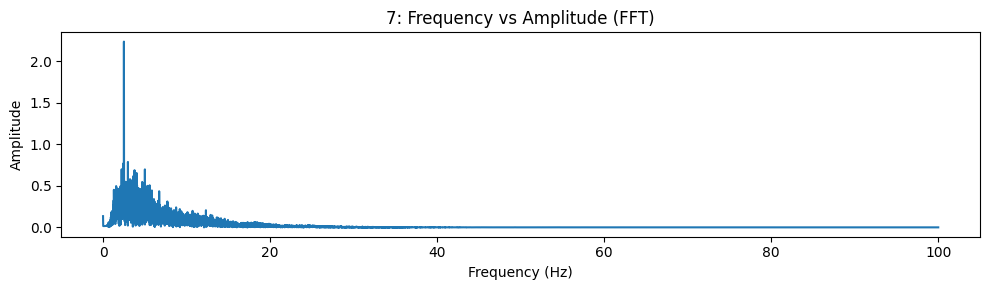

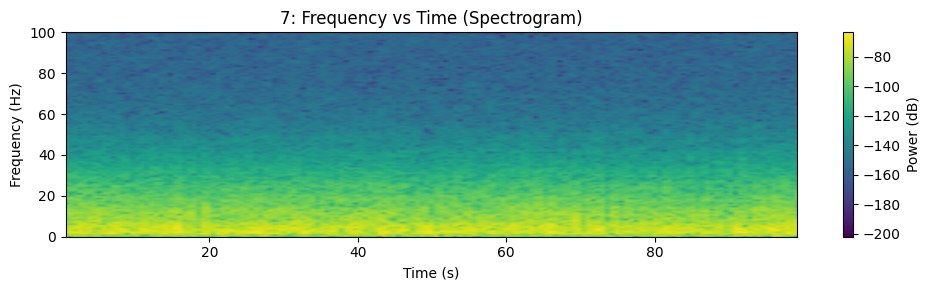

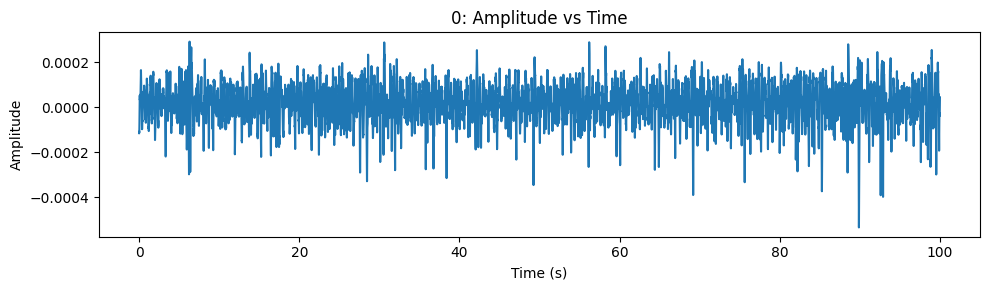

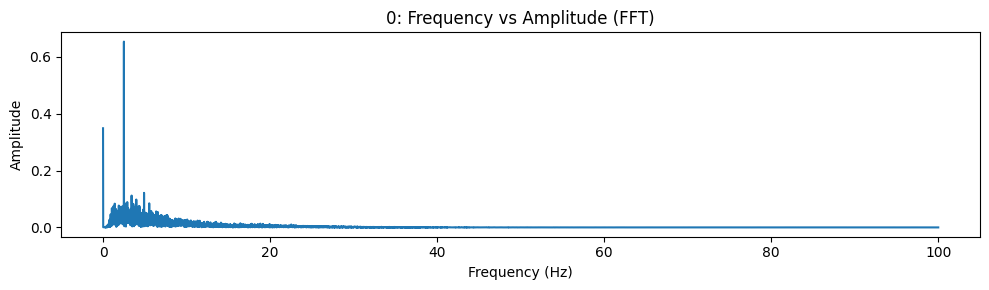

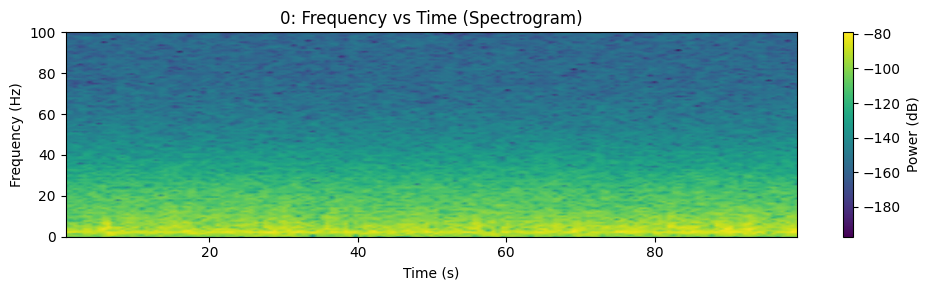

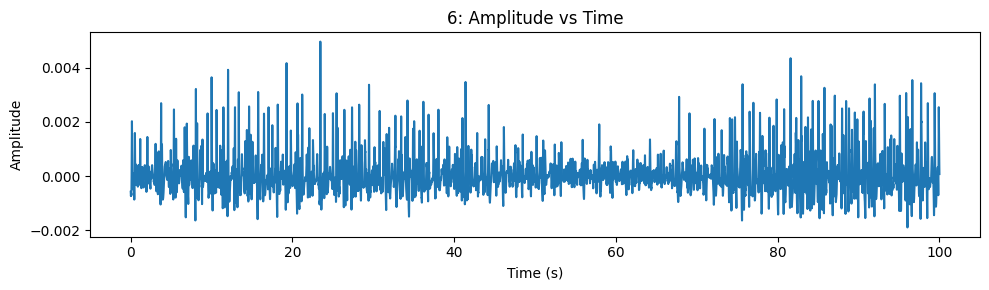

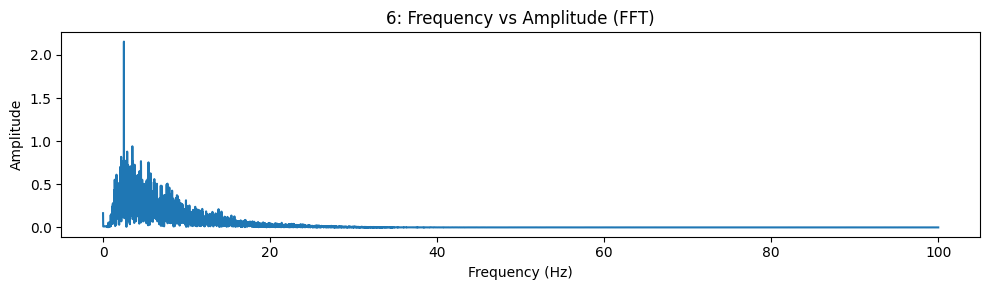

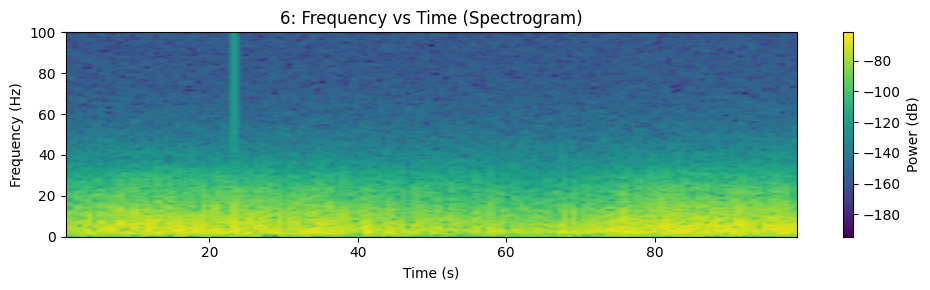

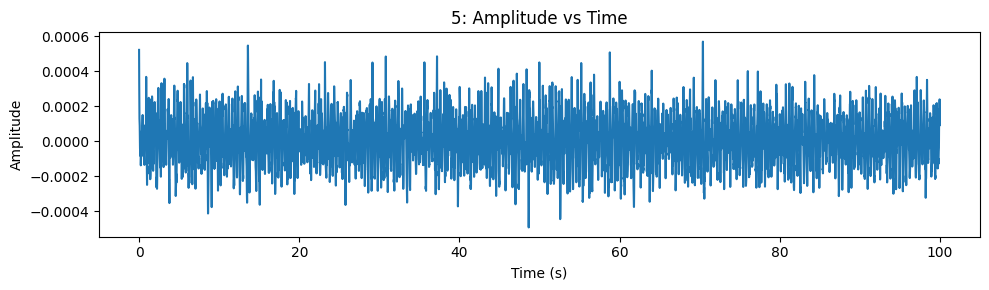

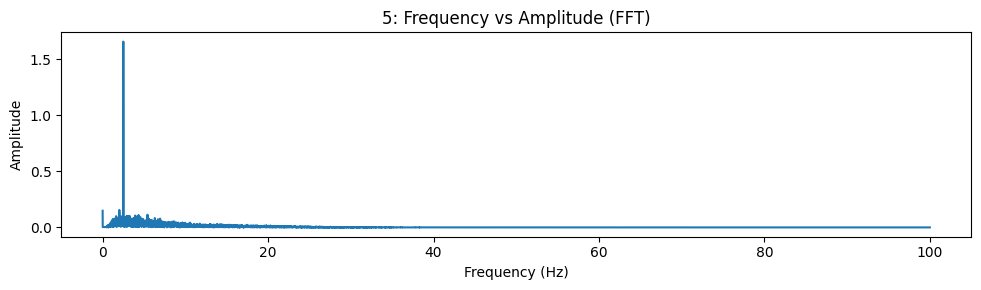

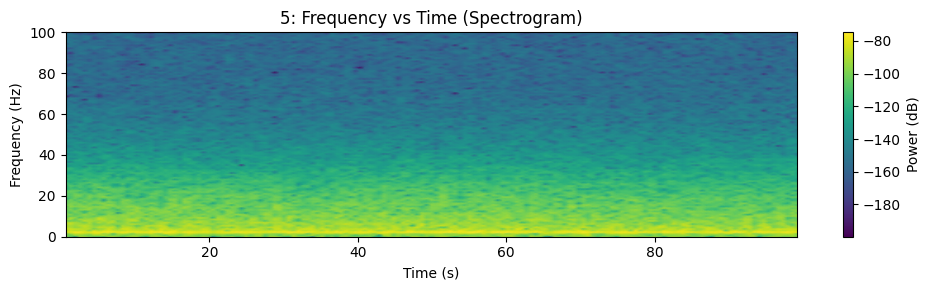

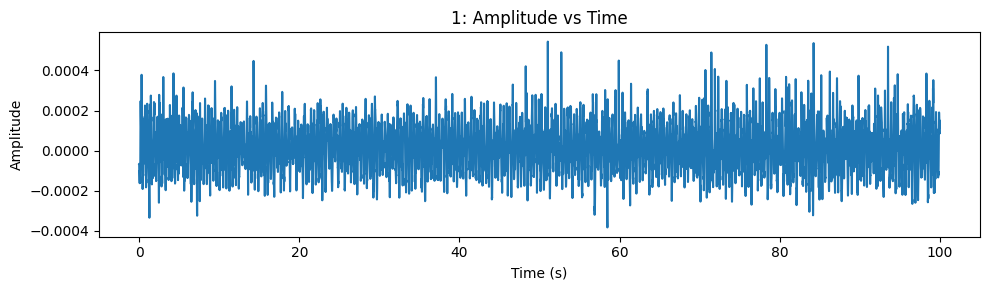

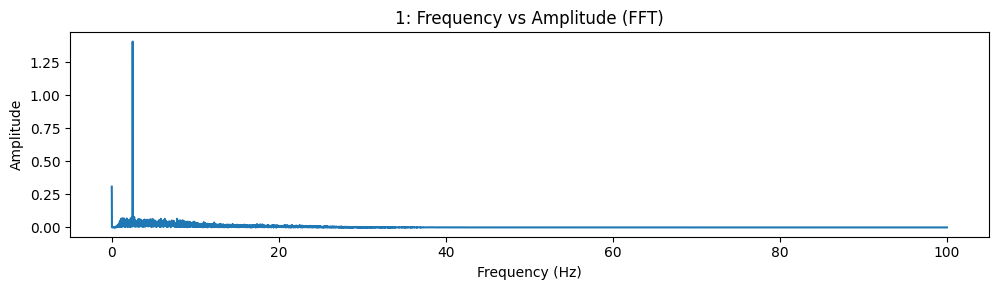

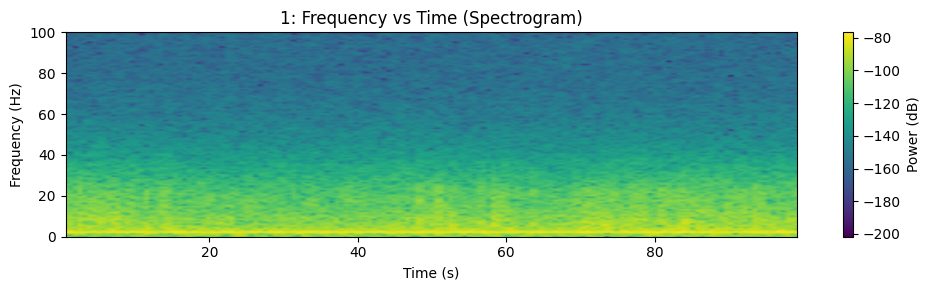

In [ ]:
fs = 200
for label, signal in example_signals.items():

    N = len(signal)
    time_axis = np.arange(N) / fs

    plt.figure(figsize=(10, 3))
    plt.plot(time_axis, signal)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"{label}: Amplitude vs Time")
    plt.tight_layout()
    plt.show()

    fft_vals = np.fft.rfft(signal)
    fft_freqs = np.fft.rfftfreq(N, 1/fs)

    plt.figure(figsize=(10, 3))
    plt.plot(fft_freqs, np.abs(fft_vals))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title(f"{label}: Frequency vs Amplitude (FFT)")
    plt.tight_layout()
    plt.show()

    freqs, times, Sxx = spectrogram(signal, fs=fs, nperseg=256, noverlap=128)

    plt.figure(figsize=(10, 3))
    plt.pcolormesh(times, freqs, 10*np.log10(Sxx), shading='gouraud')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(f"{label}: Frequency vs Time (Spectrogram)")
    plt.colorbar(label="Power (dB)")
    plt.tight_layout()
    plt.show()

# Feature Extraction

In [13]:
FS = 4000
WINDOW_MS = 300
OVERLAP_MS = 50
WIN_SIZE = int(FS * WINDOW_MS / 1000)
STEP_SIZE = int(FS * OVERLAP_MS / 1000)

In [14]:
print("Window size:", WIN_SIZE)
print("Step size:", STEP_SIZE)

Window size: 1200
Step size: 200


In [15]:
def window_signal(signal, win_size=WIN_SIZE, step=STEP_SIZE):
    windows = []
    i = 0
    L = len(signal)

    while i + win_size <= L:
        windows.append(signal[i:i+win_size])
        i += step

    return np.array(windows)

In [16]:
all_windows = []
all_window_labels = []

In [17]:
for sig, label in zip(all_signals, all_labels):
    windows = window_signal(sig)
    for w in windows:
        all_windows.append(w)
        all_window_labels.append(label)

all_windows = np.vstack(all_windows)
all_window_labels = np.array(all_window_labels)

In [18]:
print("\nTotal windows:", len(all_windows))
print("Shape of one window:", all_windows[0].shape)
print("Labels shape:", all_window_labels.shape)


Total windows: 57000
Shape of one window: (1200,)
Labels shape: (57000,)


In [19]:
def extract_features(window, fs=FS):
    features = []

    IEMG = np.sum(np.abs(window))
    MAV = np.mean(np.abs(window))
    RMS = np.sqrt(np.mean(window**2))
    VAR = np.var(window)
    WL = np.sum(np.abs(np.diff(window)))
    ZC = np.sum(((window[:-1] * window[1:]) < 0).astype(int))
    SSI = np.sum(window**2)
    LOG = np.sum(np.log1p(np.abs(window)))
    WAMP = np.sum(np.abs(np.diff(window)) > 0.01)
    MFL = np.sum(np.sqrt(1 + np.diff(window)**2))
    SSC = np.sum(((np.diff(window[:-1]) * np.diff(window[1:])) < 0).astype(int))
    MAX = np.max(np.abs(window))

    features.extend([IEMG, MAV, RMS, VAR, WL, ZC, SSI, LOG, WAMP, MFL, SSC, MAX])

    try:
        ar_model = AutoReg(window, lags=4, old_names=False).fit()
        AR = ar_model.params[1:5]
    except:
        AR = [0, 0, 0, 0]

    features.extend(AR)

    wp = pywt.WaveletPacket(data=window, wavelet='db3', maxlevel=2)

    nodes = [wp['aa'], wp['ad'], wp['da'], wp['dd']]
    coeffs = [n.data for n in nodes]

    MOAC = [np.mean(np.abs(c)) / (np.mean(np.abs(window)) + 1e-8) for c in coeffs]

    APOC = [np.sum(c**2) / len(c) for c in coeffs]

    STDOC = [np.std(c) for c in coeffs]

    RI = [
        np.mean(wp['a'].data),
        np.mean(wp['d'].data),
        np.mean(np.concatenate([wp['aa'].data, wp['ad'].data]))
    ]

    features.extend(MOAC)
    features.extend(APOC)
    features.extend(STDOC)
    features.extend(RI)

    try:
        YBS = sample_entropy(window)
    except:
        YBS = 0
    features.append(YBS)

    return np.array(features[:32])


# Dimensionality Reduction

In [20]:
feature_list = []

for w in all_windows:
    w_numeric = w.astype(np.float64)
    feature_list.append(extract_features(w_numeric))

features_array = np.vstack(feature_list)
labels_array = all_window_labels

print("Feature matrix shape:", features_array.shape)
print("Labels shape:", labels_array.shape)

Feature matrix shape: (57000, 32)
Labels shape: (57000,)


In [21]:
feature_names = [
    "IEMG", "MAV", "RMS", "VAR", "WL", "ZC", "SSI", "LOG", "WAMP", "MFL", "SSC", "MAX",
    "AR1", "AR2", "AR3", "AR4",
    "MOAC_aa", "MOAC_ad", "MOAC_da", "MOAC_dd",
    "APOC_aa", "APOC_ad", "APOC_da", "APOC_dd",
    "STDOC_aa", "STDOC_ad", "STDOC_da", "STDOC_dd",
    "RI_a_mean", "RI_d_mean", "RI_aad_mean",
    "YBS"
]


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


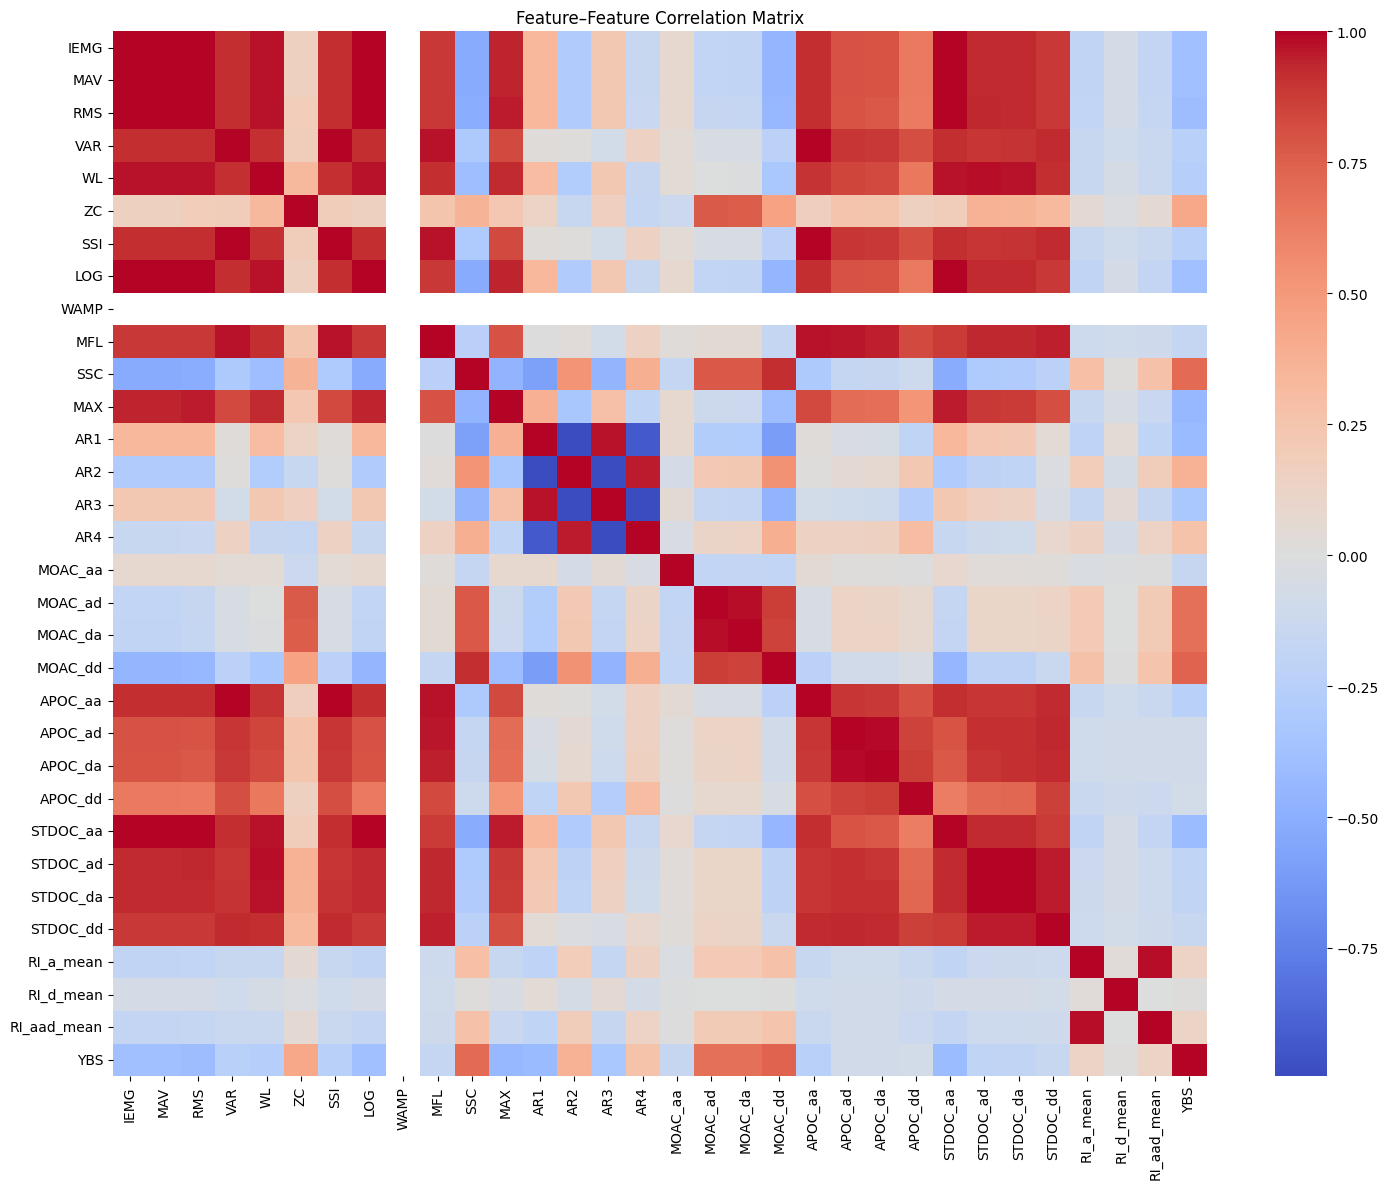

In [ ]:
corr_matrix = np.corrcoef(features_array, rowvar=False)

plt.figure(figsize=(15, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    xticklabels=feature_names,
    yticklabels=feature_names,
    annot=False
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Feature–Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [22]:
num_samples, num_features = features_array.shape
num_classes = len(np.unique(labels_array))

corr_to_labels = np.zeros((num_features, num_classes))

for c in range(num_classes):
    class_vector = (labels_array == c).astype(int)

    for f in range(num_features):
        corr, _ = pearsonr(features_array[:, f], class_vector)
        corr_to_labels[f, c] = abs(corr)

/tmp/ipython-input-892802204.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(features_array[:, f], class_vector)


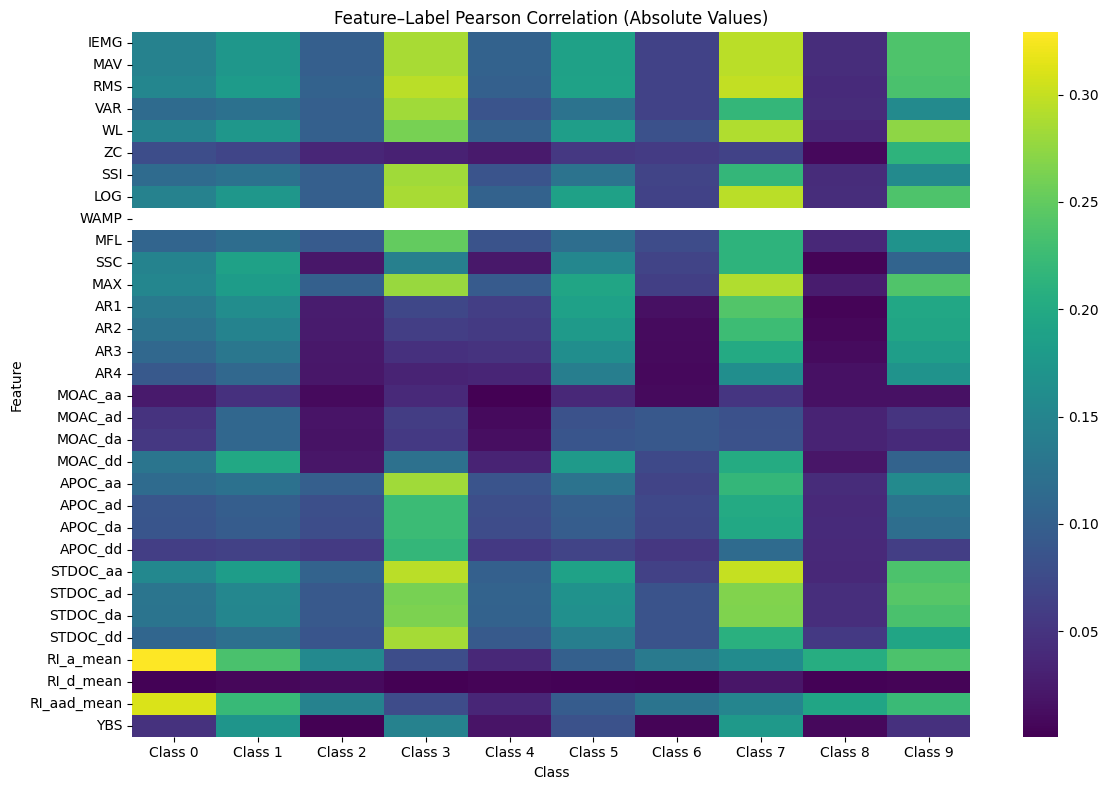

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_to_labels,
    cmap="viridis",
    annot=False,
    yticklabels=feature_names,
    xticklabels=[f"Class {i}" for i in range(num_classes)]
)
plt.title("Feature–Label Pearson Correlation (Absolute Values)")
plt.xlabel("Class")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [23]:
def pearson_filter(features, labels, threshold=0.1):
    num_samples, n_features = features.shape
    num_classes = len(np.unique(labels))

    to_keep = []

    for i in range(n_features):
        feature = features[:, i]
        max_corr = 0
        for c in range(num_classes):
            class_vector = (labels == c).astype(float)
            corr, _ = pearsonr(feature, class_vector)
            max_corr = max(max_corr, abs(corr))
        if max_corr >= threshold:
            to_keep.append(i)

    features_filtered = features[:, to_keep]
    return features_filtered, to_keep

In [24]:
def remove_highly_correlated(features, feature_names=None, threshold=0.9):
    corr_matrix = np.corrcoef(features, rowvar=False)
    n_features = corr_matrix.shape[0]
    to_remove = set()

    for i in range(n_features):
        for j in range(i + 1, n_features):
            if abs(corr_matrix[i, j]) > threshold:
                to_remove.add(j)

    features_filtered = np.delete(features, list(to_remove), axis=1)

    if feature_names:
        feature_names_filtered = [name for idx, name in enumerate(feature_names) if idx not in to_remove]
        return features_filtered, feature_names_filtered

    return features_filtered

# Models

## Models trained on features filtered using the Pearson filter and feature correlation filter

In [25]:
features_filtered, kept_indices = pearson_filter(features_array, labels_array, threshold=0.1)
feature_names_filtered = [feature_names[i] for i in kept_indices]


/tmp/ipython-input-999068208.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(feature, class_vector)


In [26]:
features_filtered_fully, feature_names_filtered_fully = remove_highly_correlated(features_filtered, feature_names_filtered, threshold=0.9)
print("Filtered feature matrix shape:", features_filtered_fully.shape)
print("Filtered feature names:", feature_names_filtered_fully)

Filtered feature matrix shape: (57000, 8)
Filtered feature names: ['IEMG', 'ZC', 'SSC', 'AR1', 'MOAC_ad', 'APOC_dd', 'RI_a_mean', 'YBS']


In [27]:
X_train_filtered_fully, X_test_filtered_fully, y_train_filtered_fully, y_test_filtered_fully = train_test_split(
    features_filtered_fully, labels_array, test_size=0.2, stratify=labels_array, random_state=42
)

In [28]:
scaler = StandardScaler()
X_train_filtered_fully = scaler.fit_transform(X_train_filtered_fully)
X_test_filtered_fully = scaler.transform(X_test_filtered_fully)

### KNN

In [29]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
}

knn = KNeighborsClassifier()

grid = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_filtered_fully, y_train_filtered_fully)

print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params: {'n_neighbors': 7}
Best CV Accuracy: 0.780372807017544



Test Accuracy: 0.7868421052631579

Confusion Matrix:
[[ 988  105   21    6   10    4    1    0    5    0]
 [ 118  915   65   14   22    4    1    0    1    0]
 [  45  106  876   34   30    5   12   11    5   16]
 [   5    9   39  878   56    6   22   70   15   40]
 [  14   44   44   50  864   40   20   21   23   20]
 [   4    6    8    9   20 1010   68    5   10    0]
 [   3    6   11   18   35   79  877   40   46   25]
 [   0    0   17   87   27   10   43  828   70   58]
 [   4    8   10   13   25   18   98   70  854   40]
 [   0    2   20   60   26    7   48   60   37  880]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1140
           1       0.76      0.80      0.78      1140
           2       0.79      0.77      0.78      1140
           3       0.75      0.77      0.76      1140
           4       0.77      0.76      0.77      1140
           5       0.85      0.89      0.87      1140
           6

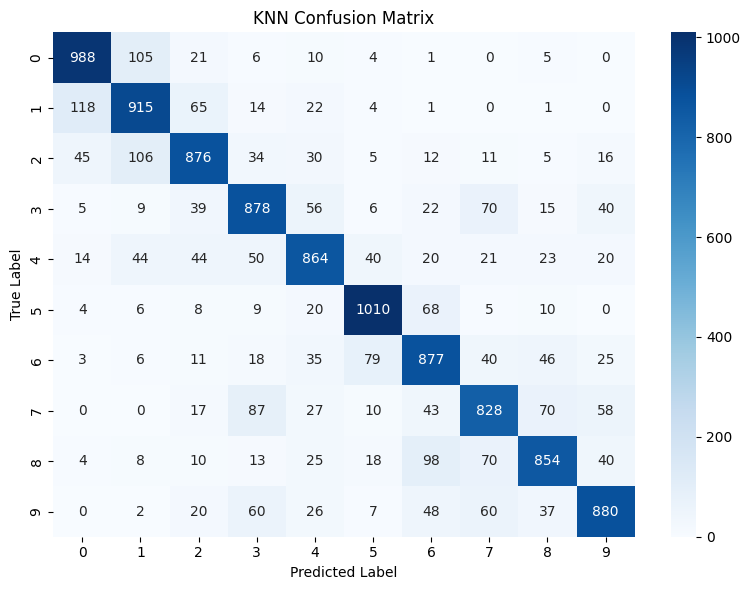

In [ ]:
best_knn = grid.best_estimator_

y_pred_knn = best_knn.predict(X_test_filtered_fully)

print("\nTest Accuracy:", accuracy_score(y_test_filtered_fully, y_pred_knn))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_filtered_fully, y_pred_knn))
print("\nClassification Report:")
print(classification_report(y_test_filtered_fully, y_pred_knn))
cm = confusion_matrix(y_test_filtered_fully, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


### SVM

SVM Accuracy: 0.7840350877192982

Confusion Matrix:
[[988 103  25   7  12   0   0   1   4   0]
 [100 920  86   7  25   2   0   0   0   0]
 [ 30 104 867  59  34   7  11   8   3  17]
 [  4  13  52 878  51   4  12  80  11  35]
 [ 10  44  33  70 806  43  46  35  28  25]
 [  0   6   6   5  17 991  99   2  12   2]
 [  0   0  12  18  18  76 878  45  54  39]
 [  0   0  13  58  23  10  62 850  64  60]
 [  3   0   4  19  16  24  78  94 875  27]
 [  0   1  13  51  19   6  72  54  39 885]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1140
           1       0.77      0.81      0.79      1140
           2       0.78      0.76      0.77      1140
           3       0.75      0.77      0.76      1140
           4       0.79      0.71      0.75      1140
           5       0.85      0.87      0.86      1140
           6       0.70      0.77      0.73      1140
           7       0.73      0.75      0.74      1140
      

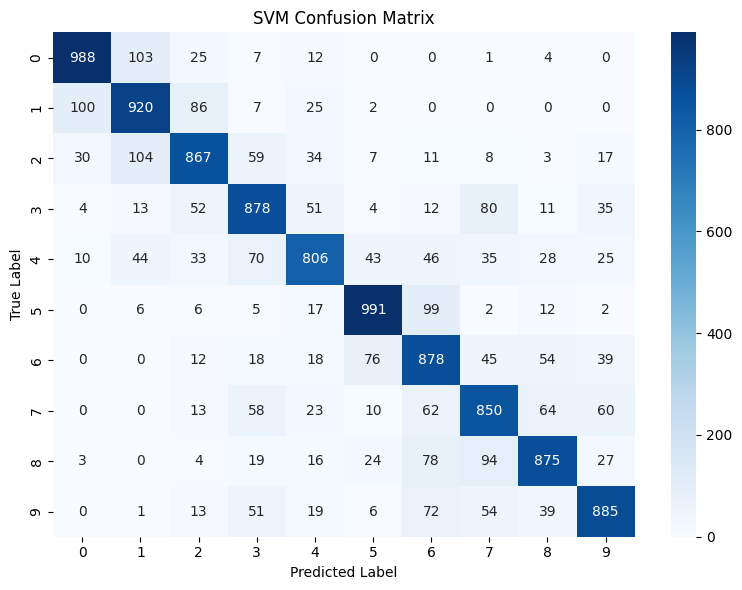

In [ ]:
svm_clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm_clf.fit(X_train_filtered_fully, y_train_filtered_fully)

y_pred_svm = svm_clf.predict(X_test_filtered_fully)

acc_svm = accuracy_score(y_test_filtered_fully, y_pred_svm)
print("SVM Accuracy:", acc_svm)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_filtered_fully, y_pred_svm))

print("\nClassification Report:")
print(classification_report(y_test_filtered_fully, y_pred_svm))

cm = confusion_matrix(y_test_filtered_fully, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### NN

In [30]:
X_train_filtered_fully = torch.tensor(X_train_filtered_fully, dtype=torch.float32)
X_test_filtered_fully = torch.tensor(X_test_filtered_fully, dtype=torch.float32)
y_train_filtered_fully = torch.tensor(y_train_filtered_fully, dtype=torch.long)
y_test_filtered_fully = torch.tensor(y_test_filtered_fully, dtype=torch.long)

In [31]:
batch_size = 32
num_features_filtered_fully = X_train_filtered_fully.shape[1]

train_dataset_filtered_fully = TensorDataset(X_train_filtered_fully, y_train_filtered_fully)
test_dataset_filtered_fully = TensorDataset(X_test_filtered_fully, y_test_filtered_fully)

train_loader_filtered_fully = DataLoader(train_dataset_filtered_fully, batch_size=batch_size, shuffle=True)
test_loader_filtered_fully = DataLoader(test_dataset_filtered_fully, batch_size=batch_size, shuffle=False)

print(num_features_filtered_fully)

8


In [32]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim=num_features_filtered_fully, num_classes=10):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),

            nn.Linear(32, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [33]:
model = MLP()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,

)

Epoch 1/100, Loss: 1.5101, Test Acc: 0.5189
Epoch 2/100, Loss: 1.1649, Test Acc: 0.6053
Epoch 3/100, Loss: 1.0225, Test Acc: 0.6300
Epoch 4/100, Loss: 0.9333, Test Acc: 0.6607
Epoch 5/100, Loss: 0.8728, Test Acc: 0.6883
Epoch 6/100, Loss: 0.8278, Test Acc: 0.6952
Epoch 7/100, Loss: 0.7959, Test Acc: 0.7104
Epoch 8/100, Loss: 0.7706, Test Acc: 0.7104
Epoch 9/100, Loss: 0.7476, Test Acc: 0.7144
Epoch 10/100, Loss: 0.7253, Test Acc: 0.7253
Epoch 11/100, Loss: 0.7082, Test Acc: 0.7329
Epoch 12/100, Loss: 0.6937, Test Acc: 0.7416
Epoch 13/100, Loss: 0.6813, Test Acc: 0.7452
Epoch 14/100, Loss: 0.6641, Test Acc: 0.7439
Epoch 15/100, Loss: 0.6551, Test Acc: 0.7337
Epoch 16/100, Loss: 0.6456, Test Acc: 0.7469
Epoch 17/100, Loss: 0.6364, Test Acc: 0.7524
Epoch 18/100, Loss: 0.6240, Test Acc: 0.7591
Epoch 19/100, Loss: 0.6197, Test Acc: 0.7668
Epoch 20/100, Loss: 0.6097, Test Acc: 0.7654
Epoch 21/100, Loss: 0.6024, Test Acc: 0.7609
Epoch 22/100, Loss: 0.5976, Test Acc: 0.7653
Epoch 23/100, Loss:

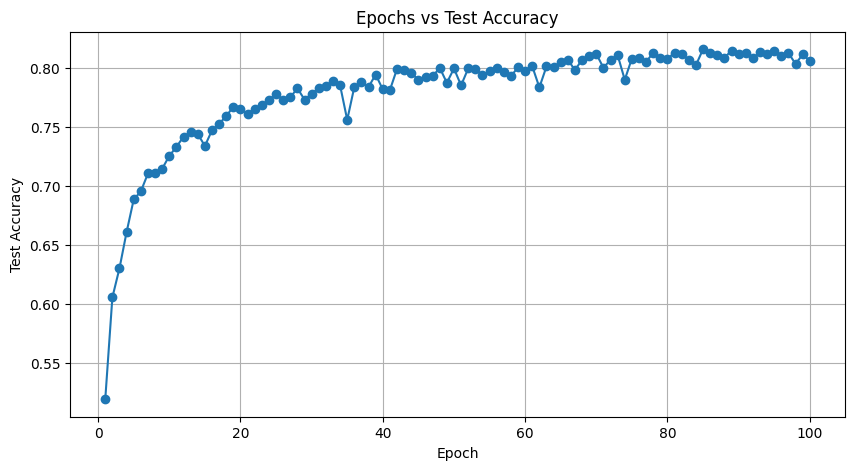

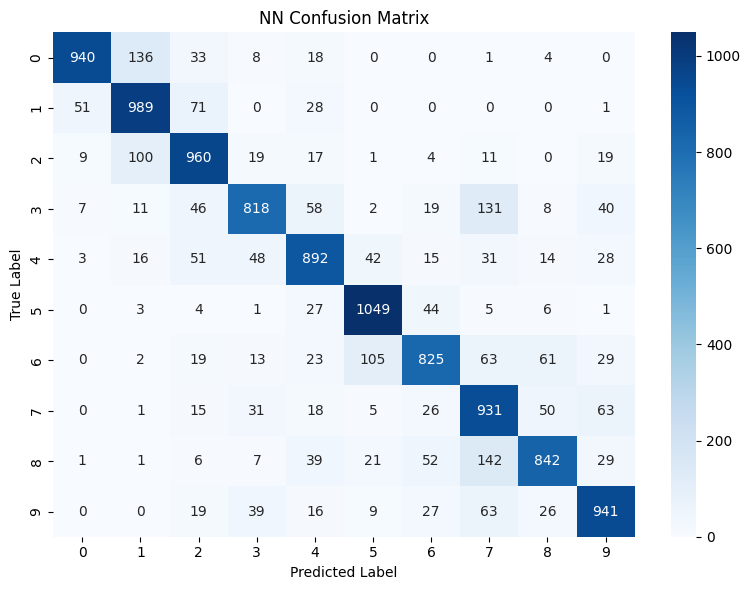

In [35]:
epochs = 100
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in train_loader_filtered_fully:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader_filtered_fully:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, preds = torch.max(outputs, 1)

            correct += (preds == yb).sum().item()
            total += yb.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    acc = correct / total
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader_filtered_fully):.4f}, Test Acc: {acc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
cr = classification_report(all_labels, all_preds)

print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), test_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Epochs vs Test Accuracy')
plt.grid(True)
plt.show()


cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("NN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## Models Trained On just the pearson Filter

### Neural Network(Using just pearson filter)

In [73]:
features_filtered, kept_indices = pearson_filter(features_array, labels_array, threshold=0.1)
feature_names_filtered = [feature_names[i] for i in kept_indices]

/tmp/ipython-input-999068208.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(feature, class_vector)


In [74]:
print("Filtered feature matrix shape:", features_filtered.shape)
print("Filtered feature names:", feature_names_filtered)

Filtered feature matrix shape: (57000, 29)
Filtered feature names: ['IEMG', 'MAV', 'RMS', 'VAR', 'WL', 'ZC', 'SSI', 'LOG', 'MFL', 'SSC', 'MAX', 'AR1', 'AR2', 'AR3', 'AR4', 'MOAC_ad', 'MOAC_da', 'MOAC_dd', 'APOC_aa', 'APOC_ad', 'APOC_da', 'APOC_dd', 'STDOC_aa', 'STDOC_ad', 'STDOC_da', 'STDOC_dd', 'RI_a_mean', 'RI_aad_mean', 'YBS']


In [75]:
X_train_pearson, X_test_pearson, y_train_pearson, y_test_pearson = train_test_split(
    features_filtered, labels_array, test_size=0.2, stratify=labels_array, random_state=42
)

In [76]:
scaler = StandardScaler()
X_train_pearson = scaler.fit_transform(X_train_pearson)
X_test_pearson = scaler.transform(X_test_pearson)

In [77]:
X_train_pearson = torch.tensor(X_train_pearson, dtype=torch.float32)
X_test_pearson = torch.tensor(X_test_pearson, dtype=torch.float32)
y_train_pearson = torch.tensor(y_train_pearson, dtype=torch.long)
y_test_pearson = torch.tensor(y_test_pearson, dtype=torch.long)

In [92]:
batch_size = 32
num_features = X_train_pearson.shape[1]

train_dataset_pearson = TensorDataset(X_train_pearson, y_train_pearson)
test_dataset_pearson = TensorDataset(X_test_pearson, y_test_pearson)

train_loader_pearson = DataLoader(train_dataset_pearson, batch_size=batch_size, shuffle=True)
test_loader_pearson = DataLoader(test_dataset_pearson, batch_size=batch_size, shuffle=False)

print(num_features)



29


In [99]:
class MLP(nn.Module):
    def __init__(self, input_dim=num_features, num_classes=10):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            # nn.Linear(input_dim, 32),
            # nn.ReLU(),

            # nn.Linear(32, 64),
            # nn.ReLU(),

            # nn.Linear(64, 128),
            # nn.ReLU(),

            # nn.Linear(128, 256),
            # nn.ReLU(),

            # nn.Linear(256, 512),
            # nn.ReLU(),

            # nn.Linear(512, 256),
            # nn.ReLU(),

            # nn.Linear(256, 128),
            # nn.ReLU(),

            # nn.Linear(128, 64),
            # nn.ReLU(),

            # nn.Linear(64, 32),
            # nn.ReLU(),

            # nn.Linear(32, num_classes)

            nn.Linear(input_dim, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, num_classes)


        )

    def forward(self, x):
        return self.net(x)

In [108]:
model = MLP()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [106]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,
    weight_decay=0.0001
)

Epoch 1/200, Loss: 1.2948, Test Acc: 0.6414
Epoch 2/200, Loss: 0.8429, Test Acc: 0.7354
Epoch 3/200, Loss: 0.6806, Test Acc: 0.7722
Epoch 4/200, Loss: 0.5931, Test Acc: 0.7808
Epoch 5/200, Loss: 0.5355, Test Acc: 0.7898
Epoch 6/200, Loss: 0.4979, Test Acc: 0.8007
Epoch 7/200, Loss: 0.4681, Test Acc: 0.8111
Epoch 8/200, Loss: 0.4490, Test Acc: 0.8175
Epoch 9/200, Loss: 0.4317, Test Acc: 0.8450
Epoch 10/200, Loss: 0.4149, Test Acc: 0.8284
Epoch 11/200, Loss: 0.4023, Test Acc: 0.8326
Epoch 12/200, Loss: 0.3887, Test Acc: 0.8386
Epoch 13/200, Loss: 0.3787, Test Acc: 0.8359
Epoch 14/200, Loss: 0.3710, Test Acc: 0.8420
Epoch 15/200, Loss: 0.3588, Test Acc: 0.8623
Epoch 16/200, Loss: 0.3555, Test Acc: 0.8616
Epoch 17/200, Loss: 0.3437, Test Acc: 0.8580
Epoch 18/200, Loss: 0.3420, Test Acc: 0.8579
Epoch 19/200, Loss: 0.3344, Test Acc: 0.8542
Epoch 20/200, Loss: 0.3259, Test Acc: 0.8629
Epoch 21/200, Loss: 0.3234, Test Acc: 0.8671
Epoch 22/200, Loss: 0.3175, Test Acc: 0.8453
Epoch 23/200, Loss:

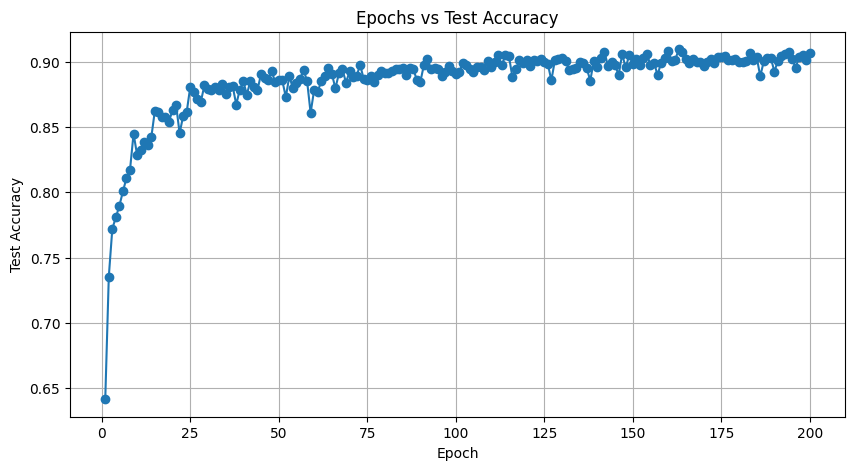

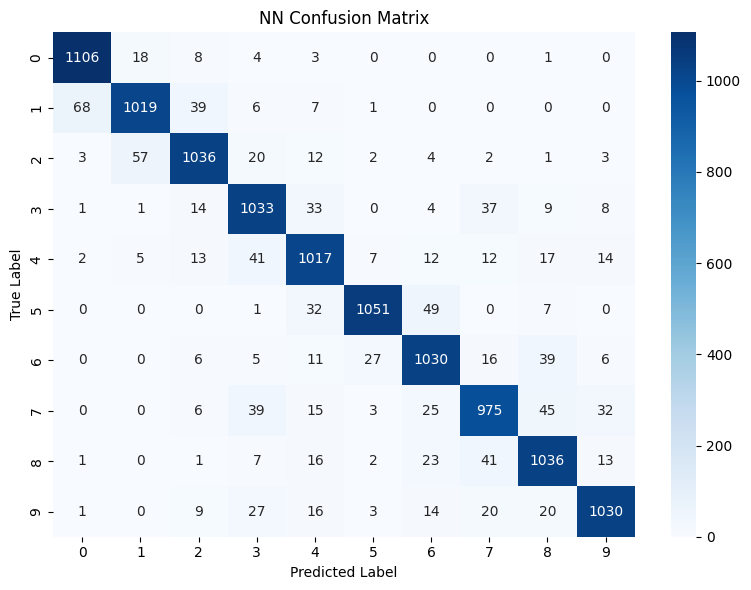

In [107]:
epochs = 200
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in train_loader_pearson:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader_pearson:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, preds = torch.max(outputs, 1)

            correct += (preds == yb).sum().item()
            total += yb.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    acc = correct / total
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader_pearson):.4f}, Test Acc: {acc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
cr = classification_report(all_labels, all_preds)

print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), test_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Epochs vs Test Accuracy')
plt.grid(True)
plt.show()


cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("NN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [46]:
X_train_pearson, X_test_pearson, y_train_pearson, y_test_pearson = train_test_split(
    features_filtered, labels_array, test_size=0.2, stratify=labels_array, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_pearson)
X_test = scaler.transform(X_test_pearson)

### KNN

In [47]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
}

knn = KNeighborsClassifier()

grid = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_pearson, y_train_pearson)

print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params: {'n_neighbors': 1}
Best CV Accuracy: 0.2998684210526316



Test Accuracy: 0.31157894736842107

Confusion Matrix:
[[388 205 127  22  59 108  79  17  69  66]
 [188 361 132  39  88 135  73  16  82  26]
 [129 134 303  71  97  71 112  31  97  95]
 [ 23  46  80 345  75  40 105 193  90 143]
 [ 76 107  86  79 310 143  87  83 110  59]
 [105 157 113  36 149 355  90  26  71  38]
 [ 86  69  87 111  91  75 341  98 123  59]
 [ 28  23  43 135  80  26  90 425 145 145]
 [ 73  68 115  80 107  87 122 123 290  75]
 [ 66  20  96 127  83  21  53 156  84 434]]

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.34      0.34      1140
           1       0.30      0.32      0.31      1140
           2       0.26      0.27      0.26      1140
           3       0.33      0.30      0.32      1140
           4       0.27      0.27      0.27      1140
           5       0.33      0.31      0.32      1140
           6       0.30      0.30      0.30      1140
           7       0.36      0.37      0.37      1140
   

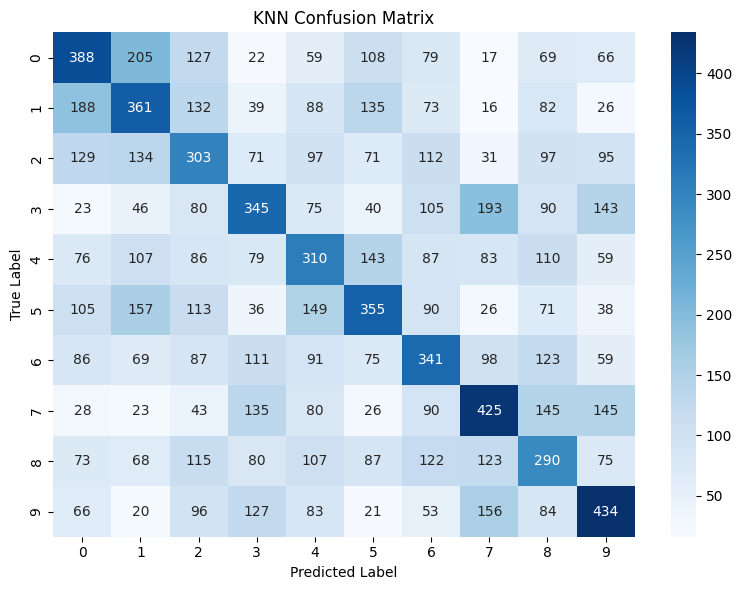

In [48]:
best_knn = grid.best_estimator_

y_pred_knn = best_knn.predict(X_test_pearson)

print("\nTest Accuracy:", accuracy_score(y_test_pearson, y_pred_knn))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_pearson, y_pred_knn))
print("\nClassification Report:")
print(classification_report(y_test_pearson, y_pred_knn))
cm = confusion_matrix(y_test_pearson, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


### SVM

SVM Accuracy: 0.19456140350877194

Confusion Matrix:
[[ 58 573  21   4   2  40 230  65  26 121]
 [ 68 615  28   1   2  67 198  70  45  46]
 [ 28 305  57  39   4  19 250 137  66 235]
 [ 44  71  90  47   5  18 136 384  52 293]
 [ 53 330  64  32   2  39 189 213  40 178]
 [ 39 513  40  12   2  45 267  44  41 137]
 [ 35 218  77  57   5  19 196 196  52 285]
 [ 17  47  71  58   2   6  78 517  19 325]
 [ 27 274  89  32   5  32 167 201  66 247]
 [ 21  41  34  57   0   7  90 231  44 615]]

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.05      0.08      1140
           1       0.21      0.54      0.30      1140
           2       0.10      0.05      0.07      1140
           3       0.14      0.04      0.06      1140
           4       0.07      0.00      0.00      1140
           5       0.15      0.04      0.06      1140
           6       0.11      0.17      0.13      1140
           7       0.25      0.45      0.32      1140
     

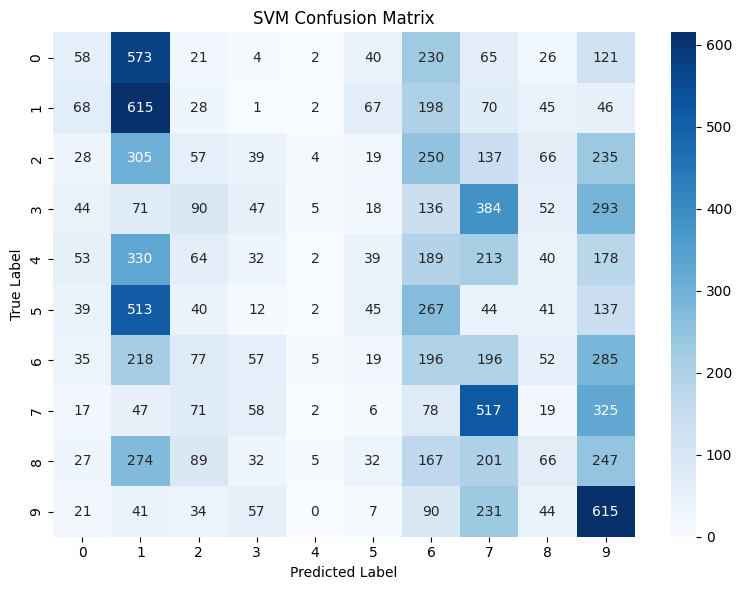

In [49]:
svm_clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm_clf.fit(X_train_pearson, y_train_pearson)

y_pred_svm = svm_clf.predict(X_test_pearson)

acc_svm = accuracy_score(y_test_pearson, y_pred_svm)
print("SVM Accuracy:", acc_svm)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_pearson, y_pred_svm))

print("\nClassification Report:")
print(classification_report(y_test_pearson, y_pred_svm))

cm = confusion_matrix(y_test_pearson, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## Models trained after LDA on pearson filtered features

In [50]:
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(
    features_filtered, labels_array, test_size=0.2, random_state=42, stratify=labels_array
)

scaler = StandardScaler()
X_train_lda = scaler.fit_transform(X_train_lda)
X_test_lda = scaler.transform(X_test_lda)

print("Train shape:", X_train_lda.shape)
print("Test shape:", X_test_lda.shape)

Train shape: (45600, 29)
Test shape: (11400, 29)


In [51]:
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(X_train_lda, y_train_lda)

X_train_lda = lda.transform(X_train_lda)
X_test_lda  = lda.transform(X_test_lda)

y_train_lda = y_train_lda
y_test_lda  = y_test_lda

print("Original training feature shape:", features_filtered.shape)
print("Reduced LDA training shape:", X_train_lda.shape)


Original training feature shape: (57000, 29)
Reduced LDA training shape: (45600, 9)


### KNN

In [52]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
}

knn = KNeighborsClassifier()

grid = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_lda, y_train_lda)

print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params: {'n_neighbors': 7}
Best CV Accuracy: 0.7755701754385964



Test Accuracy: 0.790438596491228

Confusion Matrix:
[[1026   56   24   11   11    5    0    0    7    0]
 [  78  968   56    5   11   14    0    0    7    1]
 [  31   78  929   34   20    7   15    7    9   10]
 [   8    9   38  888   52    8   19   69    7   42]
 [  10   20   20   65  895   32   26   12   29   31]
 [   2    8    8    2   31 1006   64    4   12    3]
 [   1    1   21   23   39   58  860   41   65   31]
 [   0    2   13   87   26   12   49  806   68   77]
 [   5   14   21   19   50   10   74   71  816   60]
 [   1    2   17   67   34    5   71   72   54  817]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1140
           1       0.84      0.85      0.84      1140
           2       0.81      0.81      0.81      1140
           3       0.74      0.78      0.76      1140
           4       0.77      0.79      0.78      1140
           5       0.87      0.88      0.88      1140
           6 

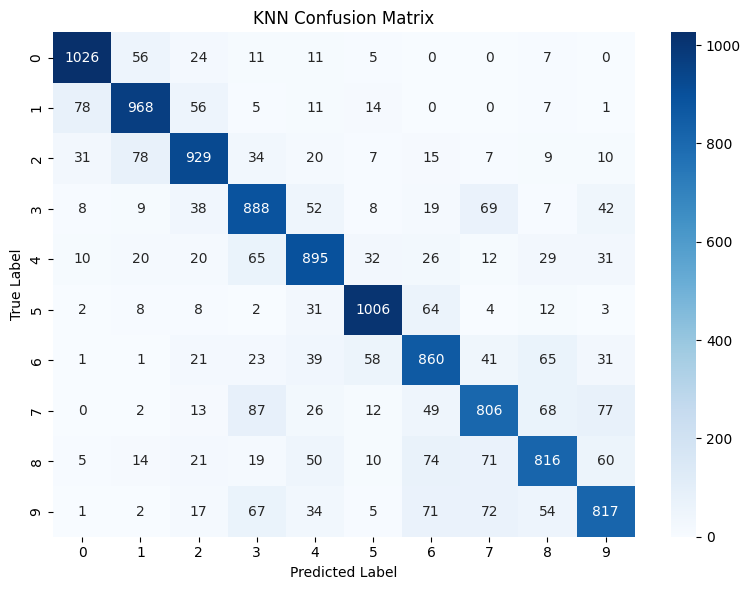

In [ ]:
best_knn = grid.best_estimator_

y_pred_knn = best_knn.predict(X_test_lda)

print("\nTest Accuracy:", accuracy_score(y_test_lda, y_pred_knn))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_lda, y_pred_knn))
print("\nClassification Report:")
print(classification_report(y_test_lda, y_pred_knn))

cm = confusion_matrix(y_test_lda, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()




### SVM

SVM Accuracy: 0.7756140350877193

Confusion Matrix:
[[999  90  23  10   7   4   0   1   6   0]
 [ 81 949  67   8  11  10   0   0  11   3]
 [ 30  63 928  47  15   6  24   5   8  14]
 [ 10   8  51 854  51   4  24  78  17  43]
 [  7  25  25  69 835  37  28  22  43  49]
 [  3  19  15   2  21 979  77   3  18   3]
 [  0   0  29  27  26  46 870  29  66  47]
 [  0   0   9  73  21  10  87 799  76  65]
 [  8   8  20  13  39  11  99  51 821  70]
 [  0   2  15  51  30   2  83  56  93 808]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1140
           1       0.82      0.83      0.82      1140
           2       0.79      0.81      0.80      1140
           3       0.74      0.75      0.74      1140
           4       0.79      0.73      0.76      1140
           5       0.88      0.86      0.87      1140
           6       0.67      0.76      0.72      1140
           7       0.77      0.70      0.73      1140
      

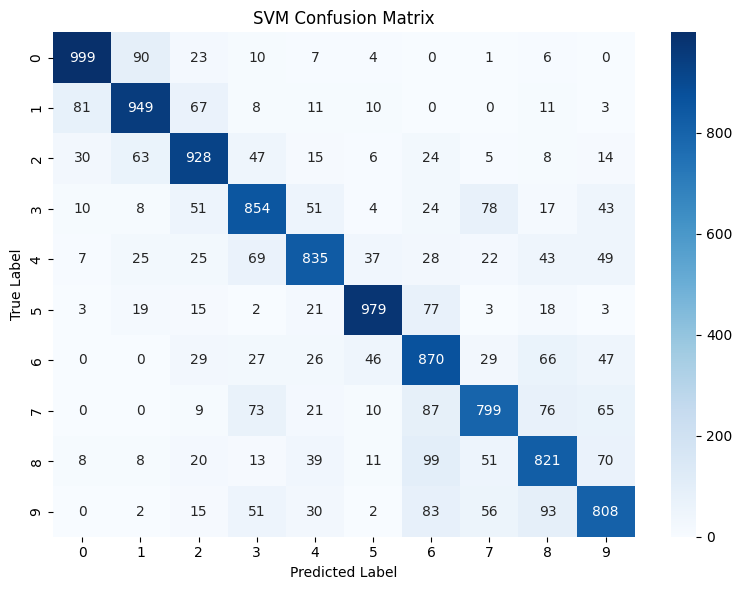

In [ ]:
svm_clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm_clf.fit(X_train_lda, y_train_lda)

y_pred_svm = svm_clf.predict(X_test_lda)

acc_svm = accuracy_score(y_test_lda, y_pred_svm)
print("SVM Accuracy:", acc_svm)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_lda, y_pred_svm))

print("\nClassification Report:")
print(classification_report(y_test_lda, y_pred_svm))

cm = confusion_matrix(y_test_lda, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### Nueral network

In [53]:
X_train_lda = torch.tensor(X_train_lda, dtype=torch.float32)
X_test_lda = torch.tensor(X_test_lda, dtype=torch.float32)
y_train_lda = torch.tensor(y_train_lda, dtype=torch.long)
y_test_lda = torch.tensor(y_test_lda, dtype=torch.long)

In [54]:
batch_size = 32
num_features = X_train_lda.shape[1]

train_dataset_lda = TensorDataset(X_train_lda, y_train_lda)
test_dataset_lda = TensorDataset(X_test_lda, y_test_lda)

train_loader_lda = DataLoader(train_dataset_lda, batch_size=batch_size, shuffle=True)
test_loader_lda = DataLoader(test_dataset_lda, batch_size=batch_size, shuffle=False)

print(num_features)

9


In [55]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim=num_features, num_classes=10):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [56]:
model = MLP()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)

Epoch 1/100, Loss: 1.4301, Test Acc: 0.5406
Epoch 2/100, Loss: 1.1212, Test Acc: 0.5946
Epoch 3/100, Loss: 1.0131, Test Acc: 0.6292
Epoch 4/100, Loss: 0.9476, Test Acc: 0.6511
Epoch 5/100, Loss: 0.9016, Test Acc: 0.6582
Epoch 6/100, Loss: 0.8683, Test Acc: 0.6711
Epoch 7/100, Loss: 0.8432, Test Acc: 0.6746
Epoch 8/100, Loss: 0.8233, Test Acc: 0.6901
Epoch 9/100, Loss: 0.8065, Test Acc: 0.7008
Epoch 10/100, Loss: 0.7928, Test Acc: 0.6973
Epoch 11/100, Loss: 0.7805, Test Acc: 0.7034
Epoch 12/100, Loss: 0.7703, Test Acc: 0.7043
Epoch 13/100, Loss: 0.7598, Test Acc: 0.7095
Epoch 14/100, Loss: 0.7507, Test Acc: 0.7181
Epoch 15/100, Loss: 0.7437, Test Acc: 0.7115
Epoch 16/100, Loss: 0.7366, Test Acc: 0.7154
Epoch 17/100, Loss: 0.7298, Test Acc: 0.7226
Epoch 18/100, Loss: 0.7242, Test Acc: 0.7240
Epoch 19/100, Loss: 0.7188, Test Acc: 0.7215
Epoch 20/100, Loss: 0.7136, Test Acc: 0.7245
Epoch 21/100, Loss: 0.7091, Test Acc: 0.7192
Epoch 22/100, Loss: 0.7048, Test Acc: 0.7213
Epoch 23/100, Loss:

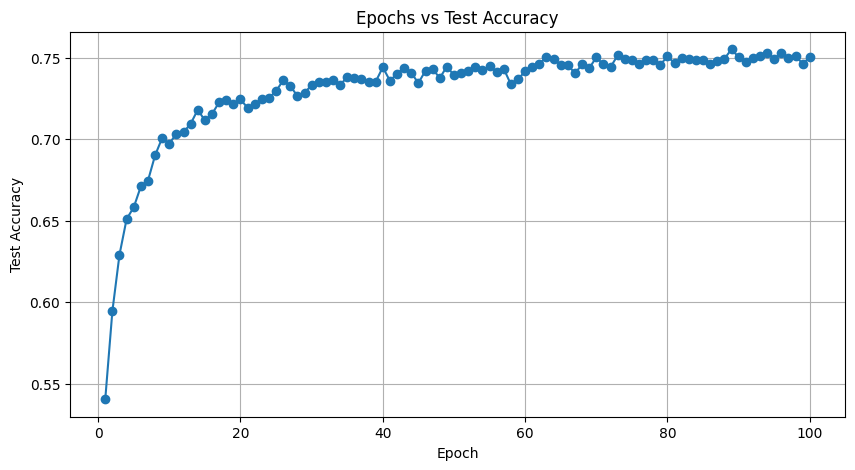

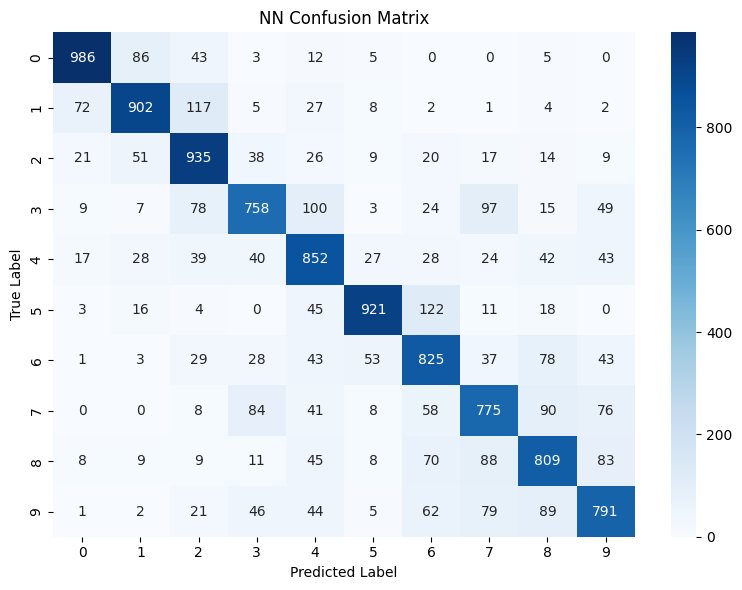

In [58]:
epochs = 100
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in train_loader_lda:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader_lda:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, preds = torch.max(outputs, 1)

            correct += (preds == yb).sum().item()
            total += yb.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    acc = correct / total
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader_lda):.4f}, Test Acc: {acc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
cr = classification_report(all_labels, all_preds)

print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), test_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Epochs vs Test Accuracy')
plt.grid(True)
plt.show()

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("NN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## PCA on pearson filter Features

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    features_filtered, labels_array, test_size=0.2, random_state=42, stratify=labels_array
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (45600, 29)
Test shape: (11400, 29)


Original feature shape: (45600, 29)
Reduced PCA feature shape: (45600, 26)


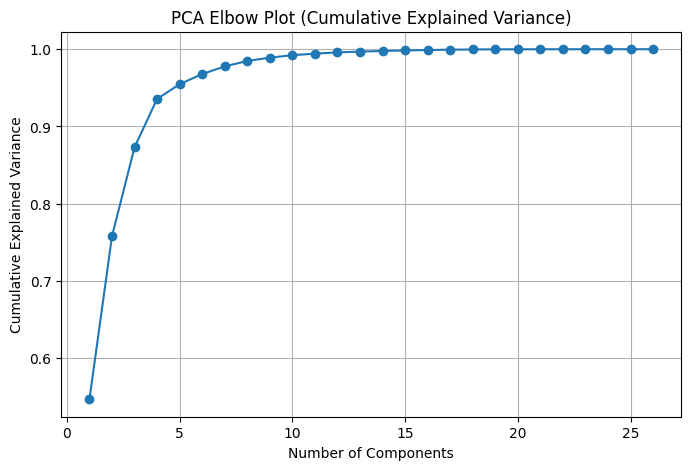

In [60]:
pca = PCA(n_components=26)
pca_features = pca.fit_transform(X_train)

print("Original feature shape:", X_train.shape)
print("Reduced PCA feature shape:", pca_features.shape)

exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)

plt.figure(figsize=(8,5))
plt.plot(range(1, 27), cum_var, marker='o')
plt.title("PCA Elbow Plot (Cumulative Explained Variance)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [61]:
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
y_train_pca = y_train
y_test_pca = y_test

print("Original feature shape:", features_filtered.shape)
print("Reduced PCA feature shape:", X_train_pca.shape)


Original feature shape: (57000, 29)
Reduced PCA feature shape: (45600, 4)


### KNN

In [65]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
}

knn = KNeighborsClassifier()

grid = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_pca, y_train_pca)

print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Params: {'n_neighbors': 9}
Best CV Accuracy: 0.7079605263157894



Test Accuracy: 0.7047368421052631

Confusion Matrix:
[[956 121  26  14   9   7   1   2   4   0]
 [148 841 102  20  21   4   2   0   1   1]
 [ 45 130 786  40  56   6  22  18   7  30]
 [ 10  20  52 779  80  11  18  99  11  60]
 [ 17  40  70  76 743  61  27  44  41  21]
 [  3   4   3  15  40 906 109  21  27  12]
 [  1   2  13  26  51 105 778  54  69  41]
 [  0   0  13 107  42  23  63 715  91  86]
 [  4   2   3  28  33  31 120 137 714  68]
 [  0   0  25  64  24  16  51  91  53 816]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1140
           1       0.72      0.74      0.73      1140
           2       0.72      0.69      0.70      1140
           3       0.67      0.68      0.67      1140
           4       0.68      0.65      0.66      1140
           5       0.77      0.79      0.78      1140
           6       0.65      0.68      0.67      1140
           7       0.61      0.63      0.62      1140
    

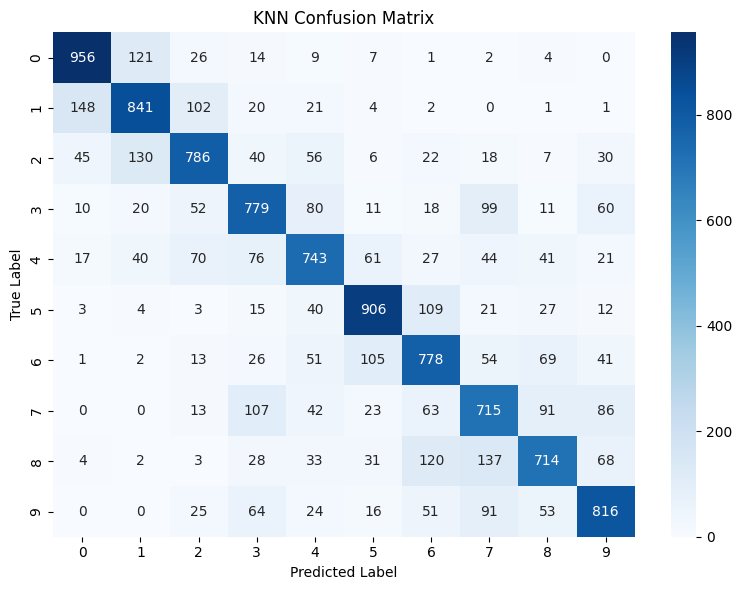

In [66]:
best_knn = grid.best_estimator_

y_pred_knn = best_knn.predict(X_test_pca)

print("\nTest Accuracy:", accuracy_score(y_test_pca, y_pred_knn))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_pca, y_pred_knn))
print("\nClassification Report:")
print(classification_report(y_test_pca, y_pred_knn))

cm = confusion_matrix(y_test_pca, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


### SVM

SVM Accuracy: 0.662719298245614

Confusion Matrix:
[[932 135  31  13  10   9   1   0   9   0]
 [163 768 137  28  24  11   7   0   2   0]
 [ 46 115 742  77  66  11  29  11   3  40]
 [ 10   9  77 741 110  10  11  93  22  57]
 [ 10  44 107  72 645  64  83  35  69  11]
 [  0  12   6  14  44 832 182   6  43   1]
 [  0   0  36  19   8 139 787  30  85  36]
 [  0   0  12  94  30  32 121 660 113  78]
 [  8   1   4  18  37  44 180 116 675  57]
 [  0   1  14  74  15   7  93  78  85 773]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1140
           1       0.71      0.67      0.69      1140
           2       0.64      0.65      0.64      1140
           3       0.64      0.65      0.65      1140
           4       0.65      0.57      0.61      1140
           5       0.72      0.73      0.72      1140
           6       0.53      0.69      0.60      1140
           7       0.64      0.58      0.61      1140
       

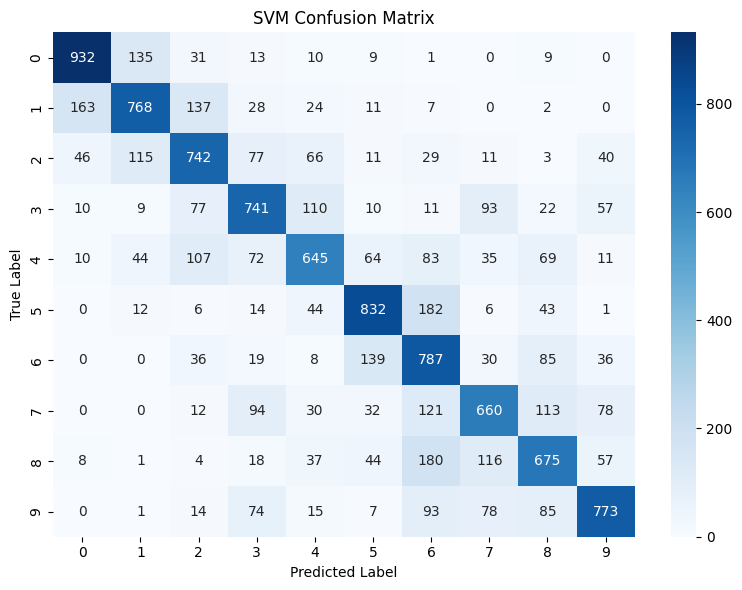

In [67]:
svm_clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm_clf.fit(X_train_pca, y_train_pca)

y_pred_svm = svm_clf.predict(X_test_pca)

acc_svm = accuracy_score(y_test_pca, y_pred_svm)
print("SVM Accuracy:", acc_svm)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_pca, y_pred_svm))

print("\nClassification Report:")
print(classification_report(y_test_pca, y_pred_svm))

cm = confusion_matrix(y_test_pca, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### Nueral Network

In [62]:
X_train_pca = torch.tensor(X_train_pca, dtype=torch.float32)
X_test_pca = torch.tensor(X_test_pca, dtype=torch.float32)
y_train_pca = torch.tensor(y_train_pca, dtype=torch.long)
y_test_pca = torch.tensor(y_test_pca, dtype=torch.long)

In [63]:
batch_size = 32
num_features = X_train_pca.shape[1]

train_dataset_pca = TensorDataset(X_train_pca, y_train_pca)
test_dataset_pca = TensorDataset(X_test_pca, y_test_pca)

train_loader_pca = DataLoader(train_dataset_pca, batch_size=batch_size, shuffle=True)
test_loader_pca = DataLoader(test_dataset_pca, batch_size=batch_size, shuffle=False)

print(num_features)

4


In [64]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim=num_features, num_classes=10):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),

            nn.Linear(8, 16),
            nn.ReLU(),

            nn.Linear(16, 32),
            nn.ReLU(),

            nn.Linear(32, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [65]:
model = MLP()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3
)

Epoch 1/100, Loss: 1.7363, Test Acc: 0.3719
Epoch 2/100, Loss: 1.4911, Test Acc: 0.4415
Epoch 3/100, Loss: 1.3653, Test Acc: 0.4796
Epoch 4/100, Loss: 1.3049, Test Acc: 0.5003
Epoch 5/100, Loss: 1.2668, Test Acc: 0.5133
Epoch 6/100, Loss: 1.2342, Test Acc: 0.5389
Epoch 7/100, Loss: 1.1921, Test Acc: 0.5520
Epoch 8/100, Loss: 1.1469, Test Acc: 0.5757
Epoch 9/100, Loss: 1.1100, Test Acc: 0.5503
Epoch 10/100, Loss: 1.0831, Test Acc: 0.5877
Epoch 11/100, Loss: 1.0622, Test Acc: 0.5718
Epoch 12/100, Loss: 1.0480, Test Acc: 0.5921
Epoch 13/100, Loss: 1.0323, Test Acc: 0.6045
Epoch 14/100, Loss: 1.0124, Test Acc: 0.6174
Epoch 15/100, Loss: 1.0020, Test Acc: 0.6061
Epoch 16/100, Loss: 0.9921, Test Acc: 0.6170
Epoch 17/100, Loss: 0.9794, Test Acc: 0.6305
Epoch 18/100, Loss: 0.9678, Test Acc: 0.6281
Epoch 19/100, Loss: 0.9624, Test Acc: 0.6324
Epoch 20/100, Loss: 0.9520, Test Acc: 0.6354
Epoch 21/100, Loss: 0.9419, Test Acc: 0.6377
Epoch 22/100, Loss: 0.9330, Test Acc: 0.6312
Epoch 23/100, Loss:

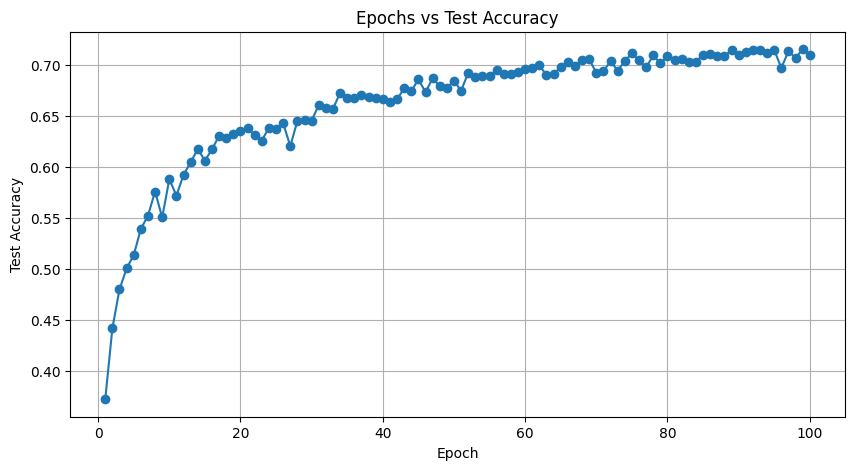

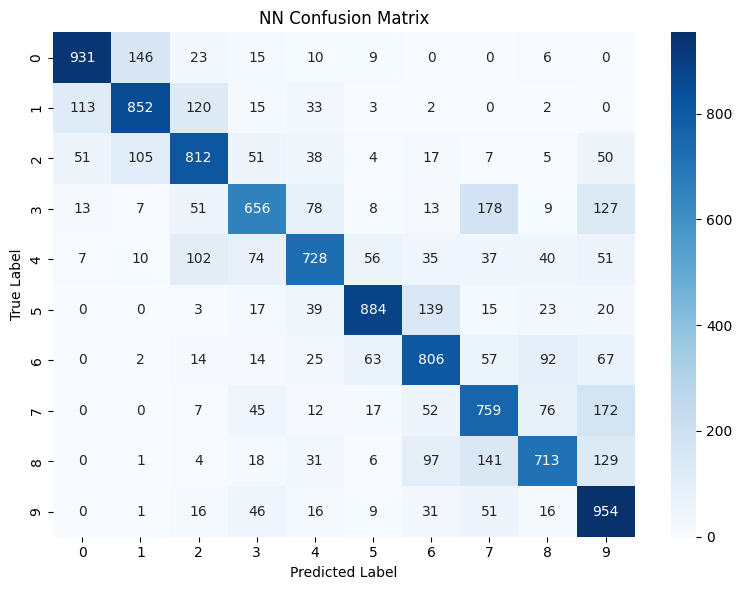

In [67]:
epochs = 100
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in train_loader_pca:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader_pca:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, preds = torch.max(outputs, 1)

            correct += (preds == yb).sum().item()
            total += yb.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    acc = correct / total
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader_pca):.4f}, Test Acc: {acc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
cr = classification_report(all_labels, all_preds)

print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), test_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Epochs vs Test Accuracy')
plt.grid(True)
plt.show()

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("NN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()